# Homework 1| Danny Stein



In [251]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
import sys
sys.path.insert(0,'C:/Users/dcste/OneDrive/fixed_income/Fixed_Income/treasury_cmds.py')
from treasury_cmds import *

In [252]:
df = pd.read_excel('C:/Users/dcste/OneDrive/fixed_income/Fixed_Income/treasury_quotes_2022-09-30.xlsx')
df.columns = df.columns.str.upper()
df.sort_values('TMATDT', inplace = True)
df.set_index('KYTREASNO', inplace = True)
df.head()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,20221004.400000,2022-09-30,99.973333,99.973444,99.973389,M,I,0.000000,-1.389258e-07,0.000067,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207774,20221006.400000,2022-09-30,99.960917,99.961083,99.961000,M,I,0.000000,-2.542594e-05,0.000065,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207893,20221011.400000,2022-09-30,99.924986,99.925292,99.925139,M,I,0.000000,1.473347e-05,0.000068,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207868,20221013.400000,2022-09-30,99.907556,99.907917,99.907736,M,I,0.000000,-8.270836e-05,0.000071,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207430,20221015.201370,2022-09-30,99.921875,99.953125,99.937500,M,I,0.631148,3.735728e-05,0.000079,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


In [253]:
t_check = df['CALDT'].values[0]
if df['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None
f'These quotes are based on {pd.to_datetime(t_current):%Y-%m-%d}'

'These quotes are based on 2022-09-30'

In [254]:
treasury_metrics = df.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
treasury_metrics.columns = ['issue date','maturity date','coupon rate','ytm','duration','outstanding']
treasury_metrics['ytm'] *= 365
treasury_metrics['duration'] /= 365
treasury_metrics['outstanding'] *= 1e6
treasury_metrics['ask-bid'] = df['TDASK'] - df['TDBID']
treasury_metrics['next cashflow date'] = (calc_cashflows(df) != 0).idxmax(1)

# Problem 1

## Part 1

For each issue, calculate its time-to-maturity, quoted in number of years, based on the maturity dates. Assume a year has exactly 365.25 days. 


In [255]:
treasury_metrics['Maturity'] = get_maturity_delta(treasury_metrics['maturity date'],t_current)
treasury_metrics['Maturity'].tail().to_frame('Maturity Dates')
treasury_metrics['Periods'] = np.round(treasury_metrics['Maturity'] *2)

## Part 2

- Calculate the dirty price for each bond issue as:

    **price = $\frac{1}{2}$ (TBID+TASK) + TDACCINT**

In [256]:
treasury_metrics['price'] = .5*(df['TDBID'] + df['TDASK']) + df['TDACCINT']
treasury_metrics['price'].to_frame("Dirty Price")

,Dirty Price
KYTREASNO,
207892,99.973389
207774,99.961000
207893,99.925139
207868,99.907736
207430,100.568648
...,...
207808,66.640625
207849,72.718750
207850,62.910156


## Yield-to-Maturity

- Calculate YTM for every bond issue. Sunday try to write a python function to calculate yield to maturity.

In [257]:
def price(coupon_rate, periods, ytm, par = 100, freq = 2):
    if periods != 0:
        cfs = [(coupon_rate/freq)*(par/100)/(1+(ytm/freq)**(i+1)) for i in range(periods)]
        discounted_face = par/(1+(ytm/freq))**periods
        return sum(cfs) + discounted_face
    else:
        return par
def ytm(coupon_rate, periods,_price, par = 100, freq = 2):
    if periods != 0:
        return optimize.newton(lambda y: price(coupon_rate, periods, y)-_price,.1, maxiter= 1000)
    else:
        return (par/_price)-1

ytm(1.5,9,89.7)

0.04193184471875915

In [258]:
treasury_metrics.loc[207777,['issue date','maturity date']]

issue date       2021-09-30 00:00:00
maturity date    2026-09-30 00:00:00
Name: 207777, dtype: object

In [259]:
for i in treasury_metrics.index:
    coupon_r = treasury_metrics.loc[i,'coupon rate']
    p = treasury_metrics.loc[i,'Periods'].astype('int')
    PRICE = treasury_metrics.loc[i,'price']
    treasury_metrics.loc[i,'YLD']  = ytm(coupon_rate = coupon_r, periods =p,_price = PRICE)

In [260]:
treasury_metrics = treasury_metrics[(treasury_metrics['YLD'] >= 0) & (treasury_metrics['YLD'] < 1) ]


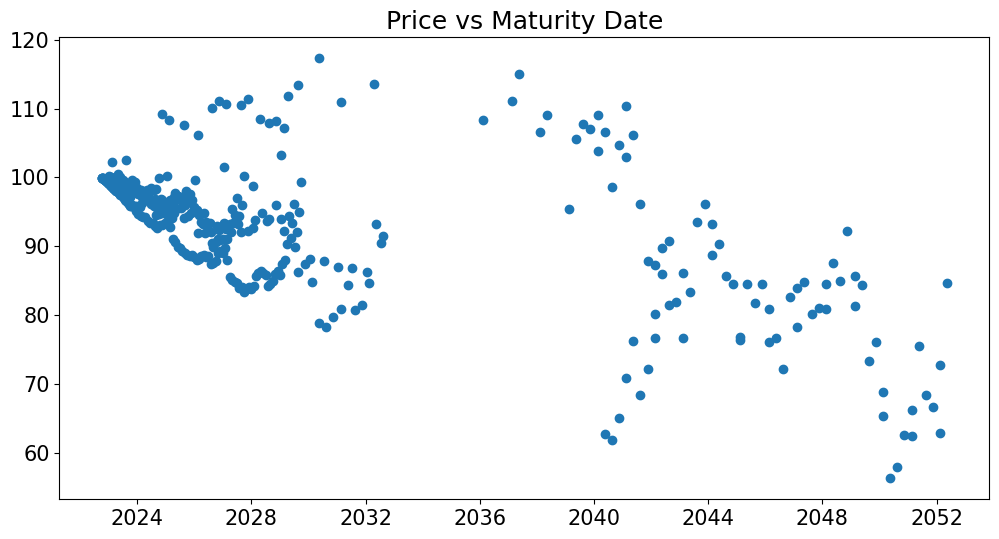

In [261]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Price vs Maturity Date')
ax.scatter(treasury_metrics['maturity date'], treasury_metrics['price'])

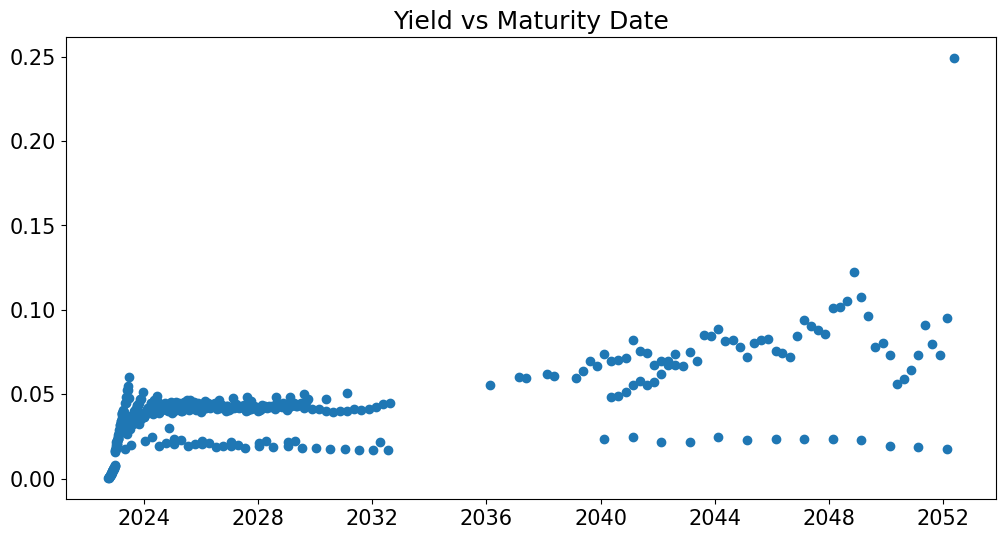

In [262]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Yield vs Maturity Date')
ax.scatter(treasury_metrics['maturity date'], treasury_metrics['YLD'])

In [264]:
treasury_metrics['YLD'].corr(treasury_metrics['ytm'])

0.44672944625729455